# A first introduction to deep knockoffs in Python

### Notebook written by Matteo Sesia and Yaniv Romano
#### Stanford University, Department of Statistics
#### Last updated on: November 18, 2018

The purpose of this notebook is to provide a simple usage example of the `DeepKnockoff` package for generating approximate knockoffs. While this code can be easily run on a laptop within a couple of minutes, more accurate knockoff machines and higher-dimensional distributions may require additional computational time or the availaibility of a graphical processing unit.

## Load the required libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from DeepKnockoffs import KnockoffMachine
from DeepKnockoffs import GaussianKnockoffs
import data
import diagnostics
import parameters

## Data generating model

We model the distribution of $X \in \mathbb{R}^p $ as multivariate Gaussian, with $p=20$ and the covariance matrix of an auto-regressive process of order one. The default correlation parameter is $\rho =0.5$.

In [2]:
# Number of features
p = 20

# Load the built-in Gaussian model and its default parameters
# The currently available built-in models are:
# - gaussian : Multivariate Gaussian distribution
# - gmm      : Gaussian mixture model
# - mstudent : Multivariate Student's-t distribution
# - sparse   : Multivariate sparse Gaussian distribution 
model = "gaussian"
distribution_params = parameters.GetDistributionParams(model, p)

# Initialize the data generator
DataSampler = data.DataSampler(distribution_params)

Let's sample $n=2000$ observations of $X$. This dataset will be used later to train a deep knockoff machine.

In [3]:
# Number of training examples
n = 2000

# Sample training data
X_train = DataSampler.sample(n)
print("Generated a training dataset of size: %d x %d." %(X_train.shape))

Generated a training dataset of size: 2000 x 20.


## Second-order knockoffs

After computing the empirical covariance matrix of $X$ in the training dataset, we can initialize a generator of second-order knockoffs. The solution of the SDP determines the pairwise correlations between the original variables and the knockoffs produced by this algorithm.

In [4]:
# Compute the empirical covariance matrix of the training data
SigmaHat = np.cov(X_train, rowvar=False)

# Initialize generator of second-order knockoffs
second_order = GaussianKnockoffs(SigmaHat, mu=np.mean(X_train,0), method="sdp")

# Measure pairwise second-order knockoff correlations 
corr_g = (np.diag(SigmaHat) - np.diag(second_order.Ds)) / np.diag(SigmaHat)

print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))

Average absolute pairwise correlation: 0.312.


## Deep knockoff machine

We initialize a deep knockoff machine with the following parameters.
The default number of epochs is small to reduce the computation time, and it should be increased to improve the accuracy of the machine. The size of the test set indicates the number of observations that should be set aside in order to monitor in real time the ability of the machine to generate knockoff copies for previously unobserved data.

In [5]:
# Load the default hyperparameters for this model
training_params = parameters.GetTrainingHyperParams(model)

# Set the parameters for training deep knockoffs
pars = dict()
# Number of epochs
pars['epochs'] = 10
# Number of iterations over the full data per epoch
pars['epoch_length'] = 20
# Data type, either "continuous" or "binary"
pars['family'] = "continuous"
# Dimensions of the data
pars['p'] = p
# Size of the test set
pars['test_size']  = int(0.1*n)
# Batch size
pars['batch_size'] = int(0.45*n)
# Learning rate
pars['lr'] = 0.01
# When to decrease learning rate (unused when equal to number of epochs)
pars['lr_milestones'] = [pars['epochs']]
# Width of the network (number of layers is fixed to 6)
pars['dim_h'] = int(10*p)
# Penalty for the MMD distance
pars['GAMMA'] = training_params['GAMMA']
# Penalty encouraging second-order knockoffs
pars['LAMBDA'] = training_params['LAMBDA']
# Decorrelation penalty hyperparameter
pars['DELTA'] = training_params['DELTA']
# Target pairwise correlations between variables and knockoffs
pars['target_corr'] = corr_g
# Kernel widths for the MMD measure (uniform weights)
pars['alphas'] = [1.,2.,4.,8.,16.,32.,64.,128.]

# Initialize the machine
machine = KnockoffMachine(pars)

Let's fit the machine to the training data. The value of the loss function on the training and test data will be printed after each epoch, along with other diagnostics based on the MMD, the matching of the covariance matrix and the pairwise correlations between variables and knockoffs.

In [6]:
# Train the machine
print("Fitting the knockoff machine...")
machine.train(X_train)

Fitting the knockoff machine...
[   1/  10], Loss: (1.0370, 1.6591), MMD: (0.3501,0.6165), Cov: (0.840,0.980), Decorr: (0.440,0.425)
[   2/  10], Loss: (0.4450, 0.8686), MMD: (0.2718,0.5294), Cov: (0.571,0.839), Decorr: (0.405,0.406)
[   3/  10], Loss: (0.3684, 0.8705), MMD: (0.2585,0.5281), Cov: (0.417,0.679), Decorr: (0.380,0.369)
[   4/  10], Loss: (0.3282, 0.7742), MMD: (0.2542,0.5150), Cov: (0.324,0.701), Decorr: (0.362,0.360)
[   5/  10], Loss: (0.3094, 0.7737), MMD: (0.2542,0.5213), Cov: (0.240,0.543), Decorr: (0.347,0.329)
[   6/  10], Loss: (0.2952, 0.7673), MMD: (0.2508,0.5386), Cov: (0.180,0.681), Decorr: (0.336,0.325)
[   7/  10], Loss: (0.2875, 0.8145), MMD: (0.2502,0.5315), Cov: (0.172,0.643), Decorr: (0.322,0.328)
[   8/  10], Loss: (0.2825, 0.8756), MMD: (0.2481,0.5296), Cov: (0.154,0.605), Decorr: (0.321,0.327)
[   9/  10], Loss: (0.2863, 0.7813), MMD: (0.2497,0.5264), Cov: (0.139,0.605), Decorr: (0.319,0.310)
[  10/  10], Loss: (0.2787, 0.7726), MMD: (0.2443,0.5106), 

## Knockoff diagnostics on the training data

The second-order method and the machine trained above can be used to generate knockoff copies of the original data.

In [7]:
# Generate deep knockoffs
Xk_train_m = machine.generate(X_train)
print("Size of the deep knockoff dataset: %d x %d." %(Xk_train_m.shape))

# Generate second-order knockoffs
Xk_train_g = second_order.generate(X_train)
print("Size of the second-order knockoff dataset: %d x %d." %(Xk_train_g.shape))

Size of the deep knockoff dataset: 2000 x 20.
Size of the second-order knockoff dataset: 2000 x 20.


The goodness of fit of the knockoffs on the training data can be assessed by checking whether the empirical covariance matrix $\hat{G}$ of $(X,\tilde{X})$ satisfies the required symmetries. Given that 
$$
\hat{G} = \begin{bmatrix}
\hat{G}_{XX} & \hat{G}_{X\tilde{X}} \\
\hat{G}_{X\tilde{X}} & \hat{G}_{\tilde{X}\tilde{X}}
\end{bmatrix},
$$
we expect that $\hat{G}_{\tilde{X}\tilde{X}} \approx \hat{G}_{XX}$ and $\hat{G}_{X\tilde{X}} \approx \hat{G}_{XX}$. The latter equality should only hold for the off-diagonal elements. The diagonal elements of $\hat{G}_{X\tilde{X}}$ should be small as possible for the knockoffs to be powerful.

Simple diagnostics can be obtained by displaying the entries of the above blocks of the covariance matrix in scatter plots.

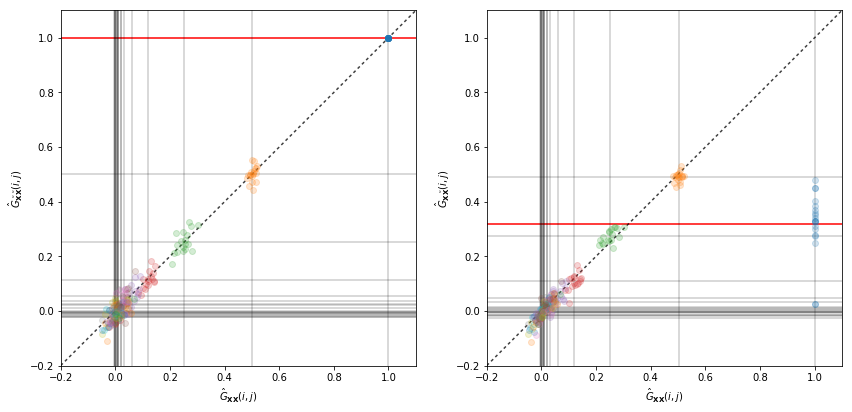

In [8]:
# Plot diagnostics for deep knockoffs
diagnostics.ScatterCovariance(X_train, Xk_train_m)

## Knockoff diagnostics on test data

The knockoff generator can be used on new observations of $X$, which we generate below.

In [9]:
# Sample test data
X_test = DataSampler.sample(n, test=True)
print("Generated a test dataset of size: %d x %d." %(X_test.shape))

Generated a test dataset of size: 2000 x 20.


Knockoffs for the test data are generated using the deep machine, the second-order method and an oracle that knows the exact distribution of $X$.

In [10]:
# Generate deep knockoffs
Xk_test_m = machine.generate(X_test)
print("Size of the deep knockoff test dataset: %d x %d." %(Xk_test_m.shape))

# Generate second-order knockoffs
Xk_test_g = second_order.generate(X_test)
print("Size of the second-order knockoff test dataset: %d x %d." %(Xk_test_g.shape))

# Generate oracle knockoffs
oracle = GaussianKnockoffs(DataSampler.Sigma, method="sdp", mu=DataSampler.mu)
Xk_test_o = oracle.generate(X_test)
print("Size of the oracle knockoff test dataset: %d x %d." %(Xk_test_o.shape))

Size of the deep knockoff test dataset: 2000 x 20.
Size of the second-order knockoff test dataset: 2000 x 20.
Size of the oracle knockoff test dataset: 2000 x 20.


A simple measure of the goodness of fit on the test data for the knockoffs generated by the deep machine is shown in the scatter plots below.

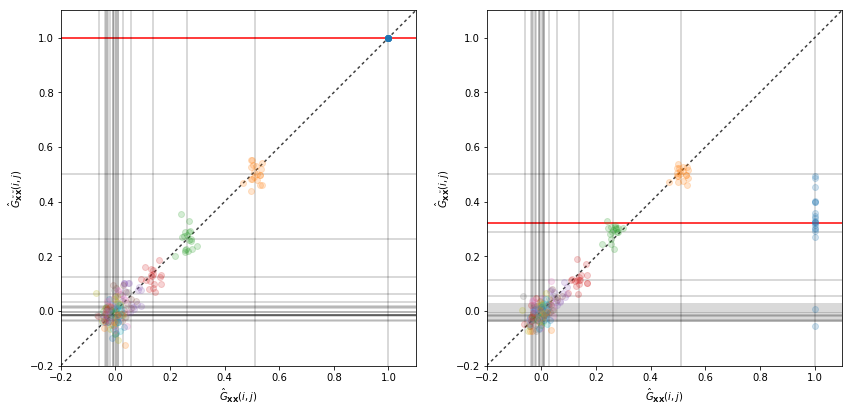

In [11]:
# Plot diagnostics for deep knockoffs
diagnostics.ScatterCovariance(X_test, Xk_test_m)

The corresponding scatter plots for the second-order knockoffs are below.

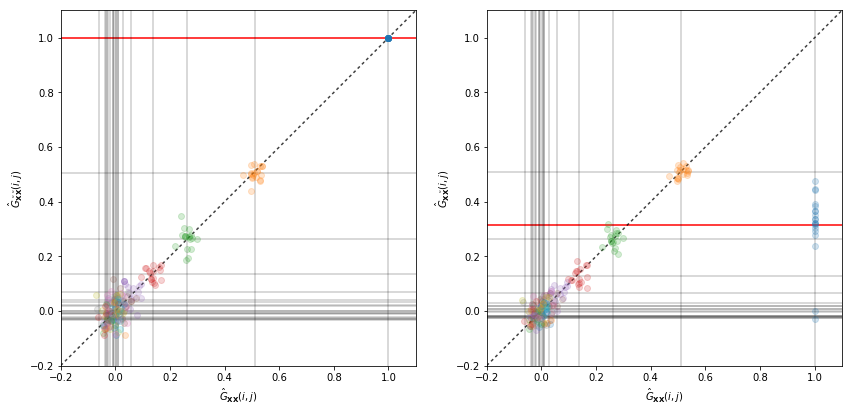

In [12]:
# Plot diagnostics for second-order knockoffs
diagnostics.ScatterCovariance(X_test, Xk_test_g)

Finally, the scatter plots for the oracle knockoffs.

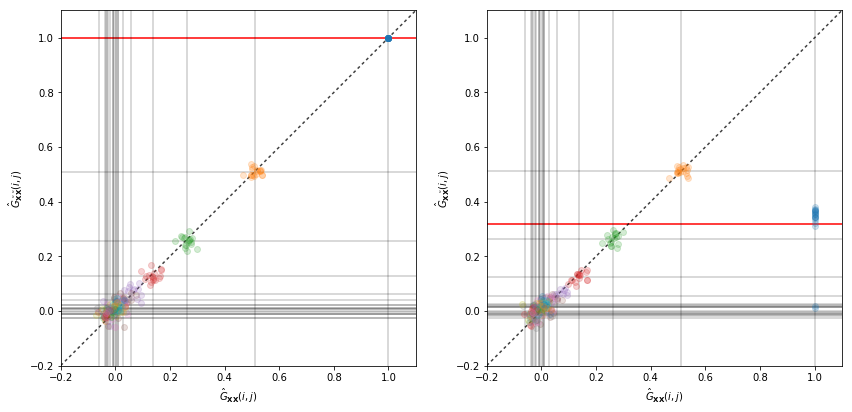

In [13]:
# Plot diagnostics for oracle knockoffs
diagnostics.ScatterCovariance(X_test, Xk_test_o)

More diagnostics can be computed by drawing new observations from the data sampler and applying the goodness-of-fit tests discussed in the paper.

In [14]:
# Compute goodness of fit diagnostics on 50 test sets containing 100 observations each
n_exams = 50
n_samples = 100
exam = diagnostics.KnockoffExam(DataSampler,
                                {'Oracle':oracle, 'Machine':machine, 'Second-order':second_order})
Diagnostics = exam.diagnose(n_samples, n_exams)

Computing knockoff diagnostics...
[=========================] 100%

The diagnostics corresponding to the covariance test are shown below.

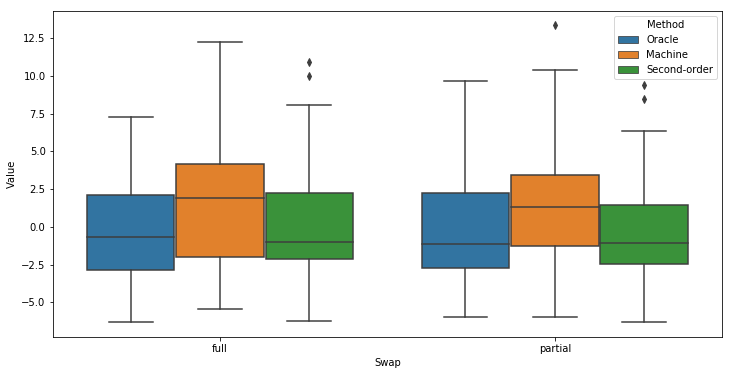

In [15]:
# Plot covariance goodness-of-fit statistics
data = Diagnostics[(Diagnostics.Metric=="Covariance") & (Diagnostics.Swap != "self")]
fig,ax =plt.subplots(figsize=(12,6))
sns.boxplot(x="Swap", y="Value", hue="Method", data=data)
fig

Similarly, we can plot the diagnostics corresponding to the $k$-nearest neighbors test.

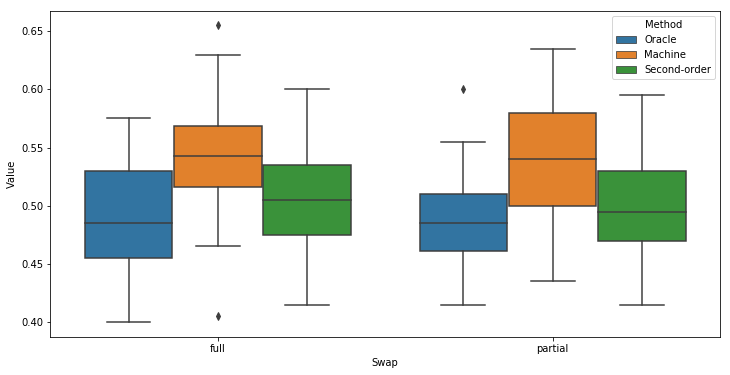

In [16]:
# Plot k-nearest neighbors goodness-of-fit statistics
data = Diagnostics[(Diagnostics.Metric=="KNN") & (Diagnostics.Swap != "self")]
fig,ax =plt.subplots(figsize=(12,6))
sns.boxplot(x="Swap", y="Value", hue="Method", data=data)
fig